**извлечение признаков из текста на естественном языке**

кластеризатор текстов   
SnowballStemmer + TFIDF + DBSCAN

_Евгений Борисов <esborisov@sevsu.ru>_

## библиотеки

In [2]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

from matplotlib import pyplot as plt

#from pymorphy2 import MorphAnalyzer

SKLEARN_VERSION

'1.0.2'

In [4]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [6]:
data.sample(2)

,text,tag
739,"Смерть младенца в роддоме Новополоцка: в действиях медиков преступления нет, но врач уволилась\n\n8 декабря 2016 в 11:27\n\nTUT.BY\n\nУправление Следственного комитета по Витебской области заверши...",incident
1072,Определились соперницы белорусских баскетболисток на ЧЕ-2017\n\n9 декабря 2016 в 22:34\n\nSPORT.TUT.BY\n\nОпределились соперницы женской сборной Беларуси по баскетболу на групповой стадии чемпиона...,sport


## токенизация и очистка

In [7]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [8]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()


stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenize_stemmer(s): 
    p = [ stemmer.stem(w).replace('^','') for w in s.split(' ') if ( w not in stopwords ) ]
    return [ w for w in p if (len(w)>1) ]


In [ ]:
# # лемматизация и очистка с помощью пакета морфологического анализа

# morph = MorphAnalyzer()

# # применяет список замен pat к строке s
# def replace_patterns(s,pat):
#     if len(pat)<1: return s
#     return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# # нормализация текста
# def string_normalizer(s):
#     pat = [
#        [r'ё','е'] # замена ё для унификации
#        ,[r'</?[a-z]+>',' '] # удаляем xml
#        ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
#        ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
#        ,[r'\w+- ',' ']
#        ,[r' +',' '] # удаляем повторы пробелов
#     ]
#     return replace_patterns(s.lower(),pat).strip()

# # NOUN (существительное), VERB (глагол), ADJF (прилагательное)
# def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
#     if not morph.word_is_known(w): return ''
#     p = morph.parse(w)[0] 
#     return p.normal_form if (p.tag.POS in pos_types) else ''


# def tokenize_normalize(s):
#     return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [9]:
data['ctext'] = data['text']\
                    .progress_apply(string_normalizer)\
                    .progress_apply(tokenize_stemmer)

  0%|          | 0/3196 [00:00<?, ?it/s]

  0%|          | 0/3196 [00:00<?, ?it/s]

In [10]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 36369 слов


In [11]:
data['ctext'] = data['ctext'].apply(' '.join)

In [12]:
data.sample(10)

,text,tag,ctext
406,В Южной Корее тысячи людей отмечают импичмент президента\n\n10 декабря 2016 в 16:09\n\nГазета.Ru\n\nВ Южной Корее несколько тысяч человек вышли на улицы и отмечают импичмент президента страны Пак ...,politics,южн кор тысяч люд отмеча импичмент президент декабр газет ru южн кор нескольк тысяч человек вышл улиц отмеча импичмент президент стран пак кын хе переда sky news фот reuters тысяч люд прошл марш в...
2638,"Ученые из Хельсинки выяснили, сколько времени на самом деле нужно спать по ночам, чтобы как следует высыпаться и хорошо себя чувствовать. Научным сотрудникам понадобилось провести целый ряд испыта...",science,учен хельсинк выясн скольк времен сам дел нужн спат ноч след высыпа чувствова научн сотрудник понадоб провест цел ряд испытан опыт выясн мужчин необходим спат сем час минут сутк женщин нужн прибли...
1810,"13.12.16 03:20\n\nВладивосток. 13 декабря. ИНТЕРФАКС - ДАЛЬНИЙ ВОСТОК - Тайфун ""Лайонрок"", обрушившийся осенью на Приморье, нанес краю ущерб свыше 7 млрд рублей, сообщил губернатор региона Владими...",incident,владивосток декабр интерфакс дальн восток тайфун лайонрок обруш осен примор нанес кра ущерб свыш млрд рубл сообщ губернатор регион владимир миклушевск сумм ущерб иф подсчита составля млрд рубл сам...
1903,"В издании Nature Astronomy опубликованы результаты исследований британских ученых из университета Уорика, изучающих экзопланету HAT-P-7 b (Kepler-2b).\n\nПо словам астрономов, по ночам в атмосфере...",science,издан nature astronomy опубликова результат исследован британск учен университет уорик изуча экзопланет hat- слов астроном ноч атмосфер планет удален земл светов лет идут дожд капл котор ин криста...
2034,"Вынос дня. «Питтсбург» не заметил сопротивления «Аризоны»\n\n«Питтсбург» в последних матчах набрал просто потрясающую форму – победная шестиматчевая серия, за время которой «пингвины» забросили 35...",sport,вынос дня питтсбург замет сопротивлен аризон питтсбург последн матч набра прост потряса форм победн шестиматчев сер врем котор пингвин заброс шайб сегодн ноч сильн пострада аризон котор провод оче...
70,Пример установки Gentoo LinuxDmitry G Zimin написал статью в которой\nкратко показал как установить Gentoo Linux.,tech,пример установк gentoo linuxdmitry zimin написа стат котор кратк показа установ gentoo linux
1737,"Сырая нефть\n\nЦены на нефть в понедельник подскочили на 5% после того, как страны, не входящие в ОПЕК, достигли соглашения насчет урезания добычи нефти на 558 тыс. баррелей. Россия дала обещание ...",economics,сыр нефт цен нефт понедельник подскоч стран входя опек достигл соглашен насчет урезан добыч нефт тыс баррел росс дал обещан уреза добыч нефт тыс баррел ден превыша половин текущ объем добыч об мар...
3105,ИА Сахалин-Курилы Представители коренных народов из Ногликского района\nполучили больше всего дипломов областного фестиваля ремесел Первый областной\nфестиваль ремесел коренных малочисленных народ...,social,сахалин-курил представител корен народ ногликск район получ диплом областн фестивал ремесел перв областн фестивал ремесел корен малочислен народ север сахалин кмнс жив традиц заверш июл перв облас...
183,"Lotus показал свой новый среднемоторный суперкар Компания Lotus\nраспространила первую информацию, касающуюся нового среднемоторного\nавтомобиля этой марки, получившего название Lotus Europe S. Да...",tech,lotus показа сво нов среднемоторн суперкар компан lotus распростран перв информац каса нов среднемоторн автомобил марк получ назван lotus europe дан новинк станет наибол крупн модел британск марк ...
550,"В Ивьевском районе лоб в лоб столкнулись Audi и Daewoo: один человек погиб, трое — пострадали\n\n4 декабря 2016 в 13:10\n\nAUTO.TUT.BY\n\nОдин человек погиб и еще три получили травмы различной сте...",incident,ивьевск район лоб лоб столкнул audi daewoo человек погиб тро пострада декабр auto tut by человек погиб получ травм различн степен тяжест лобов авар котор произошл трасс минск гродн ивьевск район с...


##  Vectorizer

In [13]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w

X = TfidfVectorizer(use_idf=True,norm='l2',tokenizer=tokenizer,token_pattern=None).fit_transform( data['ctext'] )

## кластеризируем

In [14]:
data['cluster'] = DBSCAN(eps=.85,min_samples=5).fit(X).labels_
data['cluster'].drop_duplicates().count()

52

## тестируем

In [15]:
# номер кластера, количество объектов, метки объектов
# (cluster=-1 - некластеризованные DBSCAN объекты)
cluster_descr = pd.concat([
        data[['cluster','tag']].groupby(['cluster'])['tag'].count(),
        data[['cluster','tag']].groupby(['cluster'])['tag'].apply(lambda s: set(s)).apply(' '.join)
    ],axis=1).reset_index()

cluster_descr.columns = ['cluster','count','tags']

cluster_descr

,cluster,count,tags
0,-1,2764,woman reclama science politics economics social tech incident realty sport culture auto health
1,0,6,economics
2,1,21,politics
3,2,9,politics
4,3,13,politics
5,4,5,politics
6,5,27,politics
7,6,6,politics
8,7,10,incident
9,8,11,politics


<AxesSubplot:xlabel='cluster'>

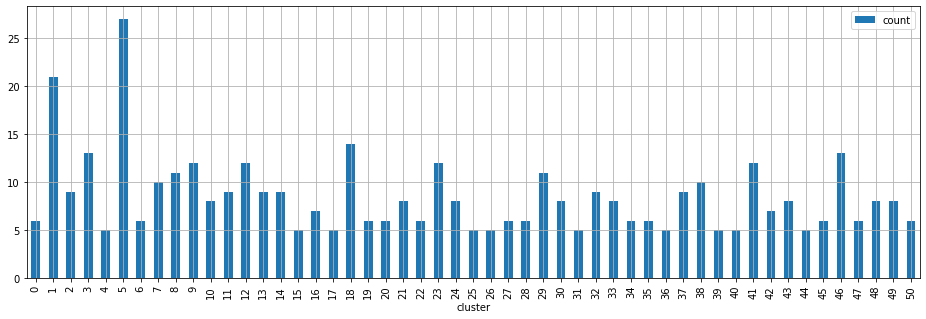

In [16]:
# размеры кластеров
cluster_descr[['cluster','count']]\
    .query('cluster>-1')\
    .set_index('cluster')\
    .plot.bar(grid=True,figsize=(16,5))

In [17]:
# def print_cluster_samples(n,ns=5,nt=100):
#     count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
#     top = [ t[:nt].replace('\n',' ') for t in data.query(f'cluster=={n}')['text'].sample(ns).values ]
#     print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
#     for s in top: print('\n%s ...\n'%(s) )

In [18]:
def print_cluster_samples(n,ns=3,nt=300):
    count,tags = cluster_descr.query(f'cluster=={n}')[['count','tags']].values[0]#.tolist
    df = data.query(f'cluster=={n}')
    ns_ = min(ns,len(df))
    top = [ t[:nt].replace('\n',' ') for t in df['text'].sample(ns_).values ]
    print('[ КЛАСТЕР %i, элементов: %i, метки: "%s" ]'%(n,count,tags))
    for s in top: print('\n%s ...\n'%(s) )

In [19]:
for n in rng.permutation(cluster_descr['cluster'].max())[:3] :
    print_cluster_samples(n)
    print('\n= = = = = = = = = = = = = = = = = = = = = = = = = =\n')

[ КЛАСТЕР 8, элементов: 11, метки: "politics" ]

ХМЕЙМИМ, 13 декабря. /ТАСС/. Сирийская армия получила контроль над 98% территории Алеппо, сообщает Центр примирения враждующих сторон.  "Сирийские власти полностью контролируют более 98% территории города Алеппо, а общая площадь кварталов в восточной части города, где остаются боевики, не превышают  ...


2137 боевиков были амнистированы. А вот в отношении 78 проводятся проверочные мероприятия Фото: REUTERS  В Сирии продолжается гуманитарная операция по выводу мирных граждан из кварталов восточного Алеппо в безопасные районы города. За последние двое суток через охраняемые коридоры в районе Карим-Хун ...


Официальный представитель Минобороны России генерал-майор Игорь Конашенков заявил, что сирийская армия установила полный контроль над 96% территории Алеппо. Об этом сообщается в пресс-релизе, поступившем в «Газету.Ru».  По его словам, площадь кварталов, где все еще остаются боевики, не превышает 8,5 ...


= = = = = = = = = = = = = = = 